# Machine Learning Essentials SS25 - Exercise Sheet 2

## Instructions
- `TODO`'s indicate where you need to complete the implementations.
- You may use external resources, but <b>write your own solutions</b>.
- Provide concise, but comprehensible comments to explain what your code does.
- Code that's unnecessarily extensive and/or not well commented will not be scored.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import multivariate_normal
np.random.seed(42)

## Exercise 1 - QDA

### Task 2

In [42]:
mu_a = np.array([-1, -1])
mu_b = np.array([1, 1])

sigma_a = np.array([[1, 0.3], [0.3, 1]])
sigma_b = np.array([[1.5, -0.2], [-0.2, 1.5]])

pooled_sigma = 1/2 * (sigma_a + sigma_b)

In [56]:
# compute the qda boundary
def qda_boundary(x, mu_a, mu_b, sigma_a, sigma_b):
    inv_sigma_a = np.linalg.inv(sigma_a)
    inv_sigma_b = np.linalg.inv(sigma_b)

    term1 = 0.5 * x.T @ (inv_sigma_b - inv_sigma_a) @ x
    w = (inv_sigma_a @ mu_a - inv_sigma_b @ mu_b).T @ x
    b = 0.5 * (mu_b.T @ inv_sigma_b @ mu_b - mu_a.T @ inv_sigma_a @ mu_a)
    return term1 + w + b

# compute the lda boundary
def lda_boundary(x, mu_a, mu_b, sigma):
    inv_sigma = np.linalg.inv(sigma)
    w = (inv_sigma @ (mu_a - mu_b)).T @ x
    b = 0.5 * (mu_b.T @ inv_sigma @ mu_b - mu_a.T @ inv_sigma @ mu_a)

    return w + b

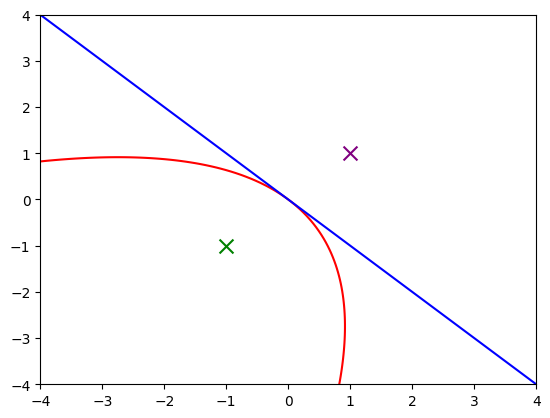

In [60]:
# Plotting
x = np.linspace(-4, 4, 100)
y = np.linspace(-4, 4, 100)
X, Y = np.meshgrid(x, y)
grid = np.c_[X.ravel(), Y.ravel()]

Z_qda = np.array([qda_boundary(p, mu_a, mu_b, sigma_a, sigma_b) for p in grid]).reshape(X.shape)
Z_lda = np.array([lda_boundary(p, mu_a, mu_b, pooled_sigma) for p in grid]).reshape(X.shape)

plt.contour(X, Y, Z_qda, levels=[0], colors='r')
plt.contour(X, Y, Z_lda, levels=[0], colors='b')
plt.scatter(mu_a[0], mu_a[1], c='green', marker='x', s=100)
plt.scatter(mu_b[0], mu_b[1], c='purple', marker='x', s=100)
plt.show()

## Exercise 2 - Implementing LDA

### Task 1

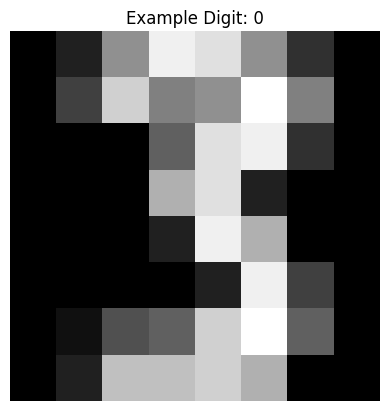

In [2]:
# TODO: Load digits dataset, visualize one example image of digit 3
digits = load_digits()

index = np.where(digits.target == 3)[0][1]
example_digit = digits.images[index]


plt.imshow(example_digit, cmap='gray')
plt.title(f"Example Digit: {digits.target[0]}")
plt.axis('off')
plt.show()

### Task 2

In [3]:
# TODO: Filter the dataset to keep only digits 3 and 9, split into training and test set (train/test = 3/2)
mask_3 = digits.target == 3
mask_9 = digits.target == 9

filtered_data = digits.data[mask_3 | mask_9]
filtered_target = digits.target[mask_3 | mask_9]

X_train, X_test, y_train, y_test = train_test_split(filtered_data, filtered_target, test_size=0.4, random_state=42)

### Task 3

In [4]:
def features_2d(data, labels):
    """
    This function takes the 64x1 feature vectors and returns a 2D representation of the data.
    """
    digit_3 = data[labels == 3]
    digit_9 = data[labels == 9]

    avg_3 = np.mean(digit_3, axis=0)
    avg_9 = np.mean(digit_9, axis=0)

    difference = avg_3 - avg_9
    
    # take the two largest values of the difference 
    # and use these pixels to create a 2D representation
    largest_indices = np.argsort(np.abs(difference))[-2:]
    
    features_2d = (data[:, largest_indices], labels)

    return features_2d

# TODO: Create an embedded dataset, provide a brief justification for your choice of embedding
data_2d, targets_2d = features_2d(X_train, y_train)
test_2d, test_targets_2d = features_2d(X_test, y_test)


Justification: 
Since we only want to distinguish between two classes we can create an average over all the images and take the difference between the two classes. Now the two pixels with the brightest value have the highest difference between the two classes. It is hopefully okay to use the labels for this. 

### Task 4

In [5]:
def pca_rep(x):
    """
    This function takes the 64x1 feature vectors and returns a 2D representation of the data. It uses PCA to reduce the dimensionality of the data to 2. PCA is a widely used algorithm for dimensionality reduction. Intuitively, PCA finds the directions in which the data varies the most and projects the data onto these directions.
    """
    # Standardize the data
    pca = PCA(n_components=2)
    return pca.fit_transform(x)

# TODO: Create a PCA-embedded dataset. Visualize & compare the embeddings. Briefly discuss the differences in separation achieved by the embeddings.
pca_data = pca_rep(X_train)
pca_test = pca_rep(X_test)


### Task 5

In [6]:
def fit_lda(training_features, training_labels):
    """
    Compute LDA parameters.
    """
    # filter features with low variance
    #mask = np.var(training_features, axis=0) > 0.001
    #training_features = training_features[:, mask]

    mu = []
    covmat = []
    p = []
    for i in np.unique(training_labels):
        features_pc = training_features[training_labels==i]
        # mu calculation
        mu_pc = np.mean(features_pc, axis=0)
        # cov calculation
        features_pcc = (features_pc - mu_pc)
        covmat_prod = features_pcc.T @ features_pcc
        mu.append(mu_pc)
        covmat.append(covmat_prod)

        # prior calculation
        p.append(features_pc.shape[0] / training_features.shape[0])

    mu = np.array(mu)

    covmat = np.sum(covmat, axis=0) / training_features.shape[0]
    p = np.array(p)
    return mu, covmat, p

# TODO: Fit seperate LDA models using your hand-crafted embedding, the PCA embedding, and the original data.
lda_2d = fit_lda(data_2d, targets_2d)

lda_pca = fit_lda(pca_data, y_train)

# filter data dimensions with less than 0.001 variance
X_train = X_train[:, np.var(X_train, axis=0) > 0.001]
X_test = X_test[:, np.var(X_test, axis=0) > 0.001]
lda_org = fit_lda(X_train, y_train)


### Task 6

In [7]:
lda_2d_mu, lda_2d_covmat, lda_2d_p = lda_2d
lda_pca_mu, lda_pca_covmat, lda_pca_p = lda_pca
lda_org_mu, lda_org_covmat, lda_org_p = lda_org

In [8]:
print(lda_2d_mu.shape)

(2, 2)


In [9]:
def predict_lda(mu, covmat, p, test_features):
    """
    Predict labels using the LDA decision rule.
    """
    # TODO: Implement the LDA decision rule
    covmat_inv = np.linalg.inv(covmat)
    w = covmat_inv @ (mu[1, :] - mu[0, :])
    b = -.5 * (mu[1, :] @ covmat_inv @ mu[1, :] - mu[0, :] @ covmat_inv @ mu[0, :]) + np.log(p[1] / p[0])
    predicted_labels = np.zeros(test_features.shape[0])
    for i in range(test_features.shape[0]):
        predicted_labels[i] = 1 if (w.T @ test_features[i, :] + b) > 0 else 0

    return predicted_labels

# TODO: Perform LDA on the filtered train sets of all 3 embeddings, evaluate on the respective test set. Report training and test error rates for all 3 embeddings. Error rate = 1 - accuracy.
lda_2d_pred = predict_lda(lda_2d_mu, lda_2d_covmat, lda_2d_p, data_2d)
lda_pca_pred = predict_lda(lda_pca_mu, lda_pca_covmat, lda_pca_p, pca_data)
lda_org_pred = predict_lda(lda_org_mu, lda_org_covmat, lda_org_p, X_train)


# report the error rates
def error_rate(predicted_labels, true_labels):
    # replace the values of 0 with 3 and 1 with 9
    predicted_labels[predicted_labels == 0] = 3
    predicted_labels[predicted_labels == 1] = 9
    return np.mean(predicted_labels != true_labels)

error_2d = error_rate(lda_2d_pred, targets_2d)
error_pca = error_rate(lda_pca_pred, y_train)
error_org = error_rate(lda_org_pred, y_train)
print(f"Error rate for original data: {error_org:.2f}")
print(f"Error rate for PCA embedding: {error_pca:.2f}")
print(f"Error rate for 2D embedding: {error_2d:.2f}")

lda_2d_test = predict_lda(lda_2d_mu, lda_2d_covmat, lda_2d_p, test_2d)
lda_pca_test = predict_lda(lda_pca_mu, lda_pca_covmat, lda_pca_p, pca_test)
lda_org_test = predict_lda(lda_org_mu, lda_org_covmat, lda_org_p, X_test)

error_2d_test = error_rate(lda_2d_test, test_targets_2d)
error_pca_test = error_rate(lda_pca_test, test_targets_2d)
error_org_test = error_rate(lda_org_test, test_targets_2d)
print(f"Test Error rate for original data: {error_org_test:.2f}")
print(f"Test Error rate for PCA embedding: {error_pca_test:.2f}")
print(f"Test Error rate for 2D embedding: {error_2d_test:.2f}")

Error rate for original data: 0.00
Error rate for PCA embedding: 0.04
Error rate for 2D embedding: 0.08
Test Error rate for original data: 0.40
Test Error rate for PCA embedding: 0.17
Test Error rate for 2D embedding: 0.19


### Task 7

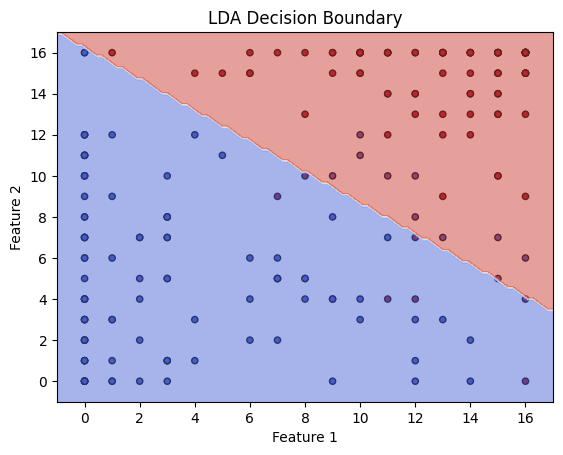

In [10]:
# TODO: For your hand-crafted embedding, visualize the decision boundary of the LDA classifier over a scatterplot of your data. Use a grid of points to visualize the decision boundary. Bonus: Visualize both Gaussian isocontours of the LDA model.

def plot_decision_boundary(mu, covmat, p, data, labels): 

    # scatter plot 
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='coolwarm', edgecolor='k', s=20)

    # min and max vals for the grid
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1

    # grid for the predictions and boundary
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    # throw grid into the LDA function to get predictions
    grid_predictions = predict_lda(mu, covmat, p, grid_points)
    grid_predictions = grid_predictions.reshape(xx.shape)

    # plot the decision boundary
    plt.contourf(xx, yy, grid_predictions, alpha=0.5, cmap='coolwarm')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title('LDA Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()
    
plot_decision_boundary(lda_2d_mu, lda_2d_covmat, lda_2d_p, data_2d, targets_2d)


### Task 8

In [ ]:
def cross_val_lda(X, y, n_splits):
    """
    Perform n-fold cross-validation for LDA using the earlier defined functions fit_lda and predict_lda."
    """
    # TODO: Implement cross-validation for LDA.
    fold_size = len(X) // n_splits
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    folds = np.array_split(indices, n_splits)
    avg_error = []
    for i in range(n_splits):
        test_indices = folds[i]
        train_indices = np.concatenate([folds[j] for j in range(n_splits) if j != i])
        
        # filter data dimensions with less than 0.001 variance
        X_train, X_test = X[train_indices, :], X[test_indices, :]
        y_train, y_test = y[train_indices], y[test_indices]

        # filter data dimensions with less than 0.001 variance
        var_indices = np.var(X_train, axis=0) > 0.001
        X_train = X_train[:, var_indices]
        X_test = X_test[:, var_indices]

        mu, covmat, p = fit_lda(X_train, y_train)
        predictions = predict_lda(mu, covmat, p, X_test)
        
        error = error_rate(predictions, y_test)
        avg_error.append(error)

    avg = np.mean(avg_error)
    return avg, np.std(avg_error)/np.sqrt(n_splits)

# TODO: Perform 10-fold CV on the original data. Report average test error rate and its standard error. Compare with the test error rate of the LDA model trained on the full dataset.

n_splits = 10 
average, standard_error = cross_val_lda(filtered_data, filtered_target, n_splits)

print(f"Average error: {average:.2f}")
print(f"Standard error: {standard_error:.2f}")


Average test error rate from 10-fold CV: 0.06
Standard error of test error rate from 10-fold CV: 0.05


Compared to the error from task 2.6 trained on the entire data set the average test error rate is much lower with 10 fold cross validation.

# Exercise 3 - Statistical Darts

### Task 1

In [14]:
def simulate_data(mu_true, Sigma_true, n_samples):
    # TODO: Simulate data from a bivariate Gaussian distribution given the mean and covariance.
    
    # Sample
    data = np.random.multivariate_normal(mu_true, Sigma_true, n_samples)

    return data

### Task 2

In [15]:
def compute_mle(data):
    # TODO: Compute the MLE for the mean of a Gaussian distribution.
    mu_mle = np.mean(data, axis=0)
    return mu_mle

### Task 3

In [16]:
def compute_posterior(data, prior, Sigma_true):
    # TODO: Compute the parameters of the posterior distribution for the unknown mean mu.
    sigma_inv = np.linalg.inv(Sigma_true)
    
    sigma_prior_inv = np.linalg.inv(prior['Sigma0'])
    mu_prior = prior['mu0'] 

    mu_mle = compute_mle(data)

    n = data.shape[0]

    Sigma_post = np.linalg.inv(sigma_prior_inv + n * sigma_inv)
    mu_post = Sigma_post @ (sigma_prior_inv @ mu_prior + n * sigma_inv @ mu_mle)

    return mu_post, Sigma_post

def compute_map(data, prior, Sigma_true):
    # TODO: Assign mean of the posterior to mu_map.
    mu_map, _ = compute_posterior(data, prior, Sigma_true)
    return mu_map

### Task 4

In [17]:
def visualize_inference(mu_true, mu_mle, mu_map, mu_post, Sigma_post, data,
                        grid_limits=[-1, 1, -1, 1], n_points=100):
    """
    Visualizes the full posterior distribution as Gaussian isocontours over a 2D grid with dartboard-like background,
    alongside the true mean, MLE estimate, MAP estimate and the simulated data points.

    Additional parameters:
        grid_limits: [xmin, xmax, ymin, ymax] limits for the 2D grid.
        n_points: Number of grid points per axis.
    """

    # Define the grid
    xmin, xmax, ymin, ymax = grid_limits
    x = np.linspace(xmin, xmax, n_points)
    y = np.linspace(ymin, ymax, n_points)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))

    # Get the posterior distribution
    rv = multivariate_normal(mu_post, Sigma_post)
    # Evaluate the pdf of the posterior @ the grid points
    Z = rv.pdf(pos)
    
    # Compute some contour levels
    levels = np.linspace(Z.max()*0.05, Z.max()*0.95, 7)

    plt.figure(figsize=(8, 6), facecolor='white')

    # Plot a dartboard-like background (concentric circles)
    center = [0,0]
    radius = 0.8 
    for r in [radius, radius*0.8, radius*0.6, radius*0.4, radius*0.2]:
        circle = plt.Circle(center, r, fill=False, color='black')
        plt.gca().add_artist(circle)
    plt.axis('equal')

    # Add bullseye
    plt.plot(center[0], center[1], 'o', markersize=10, c='red')

    # Plot isocontours of  posterior
    contour = plt.contour(X, Y, Z, levels=levels, cmap='viridis',linewidths=1)

    # Add labels to the isocontours (off by default for visibility)
    # plt.clabel(contour, inline=True, fontsize=8, fmt="%.1f")

    # Plot observed data points
    plt.scatter(data[:, 0], data[:, 1], c='gray', edgecolor='k', alpha=0.6, label='Data')

    # Plot true mean (ground truth)
    plt.scatter(mu_true[0], mu_true[1], c='black', marker='*', s=200, label='True aiming spot')

    # Plot MLE estimate
    plt.scatter(mu_mle[0], mu_mle[1], c='green', marker='x', s=100, label='MLE Estimate')

    # Plot MAP estimate 
    plt.scatter(mu_map[0], mu_map[1], c='blue', marker='x', s=100, label='MAP Estimate')

    plt.title("True Mean, posterior uncertainty, MLE & MAP on the dart board")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.legend()
    plt.grid(False)

    plt.show()

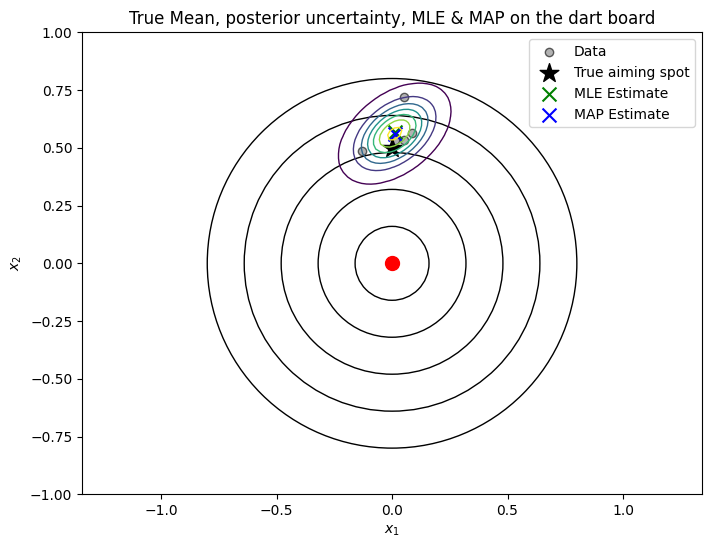

MLE estimate for N=5: [0.01373079 0.56635865]
MAP estimate for N=5: [0.01136981 0.56181862]
Posterior covariance for N=5:
 [[0.00988543 0.00392903]
 [0.00392903 0.00792092]]


In [40]:
# Ground truth parameters for the dart throws:
mu_true = np.array([0, 0.50])
Sigma_true = np.array([[0.05, 0.02],
                       [0.02, 0.04]])

# Prior for mu - standard normal around the bullseye
prior = {
    "mu0": np.array([0, 0]),
    "Sigma0": np.eye(2)
}

# TODO: Simulate data, compute MLE, MAP and posterior
n_samples = 5
data = simulate_data(mu_true, Sigma_true, n_samples=n_samples)
mu_mle = compute_mle(data)

mu_map = compute_map(data, prior, Sigma_true)
mu_post, Sigma_post = compute_posterior(data, prior, Sigma_true)



# Visualize the inference
visualize_inference(mu_true, mu_mle, mu_map, mu_post, Sigma_post, data)
print(f"MLE estimate for N={n_samples}:", mu_mle)
print(f"MAP estimate for N={n_samples}:", mu_map)
print(f"Posterior covariance for N={n_samples}:\n", Sigma_post)

# TODO: Assess results (see exercise sheet)